## Load libraries & data

In [15]:
import numpy as np
import pandas as pd
import PIL
import glob
import shutil
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import model_from_json

from quiver_engine.server import launch

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
all_data = pd.read_csv('../painting_data/kaggle_paint_numbers/csv/all_data_info.csv')
print('shape:', all_data.shape)
all_data.head()

shape: (103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


## Train a CNN using augmented images

### Data Augmentation

In [3]:
original = load_img('../painting_data/kaggle_paint_numbers/resized_72_train/52390.jpg')  
x = img_to_array(original)  
x = np.expand_dims(x, axis=0)

In [4]:
datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect')

original image:


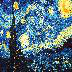

augmented images:


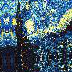

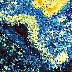

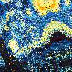

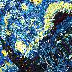

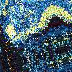

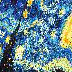

In [5]:
print('original image:')
display(original)

print('augmented images:')
augmented_image = datagen.flow(x, batch_size=1)
for i, img_ in enumerate(augmented_image):
    img_ = next(augmented_image)[0]
    display(array_to_img(img_))
    if i == 5:
        break

### Subset into Train and Test 

In [6]:
train_paintings = all_data[all_data.in_train]
train_paintings.shape

(79433, 12)

In [7]:
test_paintings = all_data[~all_data.in_train]
test_paintings.shape

(23817, 12)

In [8]:
cezanne_vangogh_train = train_paintings[(train_paintings.artist == 'Vincent van Gogh') | (train_paintings.artist == 'Paul Cezanne')]
cezanne_vangogh_train.reset_index(drop=True, inplace=True)
print(cezanne_vangogh_train.shape)
cezanne_vangogh_train.head()

(804, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg
2,Paul Cezanne,1880,genre painting,3176.0,2939.0,1338046.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,True,46247.jpg
3,Paul Cezanne,1880,genre painting,3176.0,2874.0,1146603.0,wikiart,Post-Impressionism,Bathers,train_and_test,True,63504.jpg
4,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg


In [9]:
cezanne_vangogh_train.artist.value_counts()

Paul Cezanne        412
Vincent van Gogh    392
Name: artist, dtype: int64

In [10]:
cezanne_vangogh_test = test_paintings[(test_paintings.artist == 'Vincent van Gogh') | (test_paintings.artist == 'Paul Cezanne')]
cezanne_vangogh_test.reset_index(drop=True, inplace=True)
print(cezanne_vangogh_test.shape)
cezanne_vangogh_test.head()

(189, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Paul Cezanne,1878,genre painting,3176.0,2618.0,1139110.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,False,19446.jpg
1,Paul Cezanne,1894,still life,3176.0,2606.0,737724.0,wikiart,Post-Impressionism,"Curtain, Jug and Fruit",train_and_test,False,94593.jpg
2,Paul Cezanne,1877,symbolic painting,3176.0,2600.0,958500.0,wikiart,Impressionism,The Eternal Woman,train_and_test,False,64480.jpg
3,Paul Cezanne,c.1905,landscape,3176.0,2552.0,836544.0,wikiart,Cubism,Montagne Sainte-Victoire and the Black Chateau,train_and_test,False,71902.jpg
4,Paul Cezanne,c.1890,landscape,3176.0,2551.0,811453.0,wikiart,Post-Impressionism,Mont Sainte-Victoire,train_and_test,False,11113.jpg


In [11]:
cezanne_vangogh_test.artist.value_counts()

Vincent van Gogh    102
Paul Cezanne         87
Name: artist, dtype: int64

### Create directory structure to use with  `.flow_from_directory`
Keras mehod that takes a path to a directory and generates batches of augmented/normalized data... yields batches indefinitely, in an infinite loop

In [12]:
# ####  Training images — Cezanne

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train

# cezanne_file_list = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Paul Cezanne'].new_filename.tolist()
# cezanne_filepath_list = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in cezanne_file_list]

# cezanne_filepath_list[:5]

# for fname in cezanne_filepath_list:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/train/cezanne')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train/cezanne | wc -l

# ####  Training images —  van Gogh 

# vangogh_file_list = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Vincent van Gogh'].new_filename.tolist()
# vangogh_filepath_list = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in vangogh_file_list]

# vangogh_filepath_list[:5]

# for fname in vangogh_filepath_list:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/train/vangogh')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train/vangogh | wc -l

# ####  Validation images — Cezanne

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation

# cezanne_file_list_test = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Paul Cezanne'].new_filename.tolist()
# cezanne_filepath_list_test = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in cezanne_file_list_test]

# cezanne_filepath_list_test[:5]

# for fname in cezanne_filepath_list_test:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/validation/cezanne')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation/cezanne | wc -l

# ####  Validation images — van Gogh

# vangogh_file_list_test = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Vincent van Gogh'].new_filename.tolist()
# vangogh_filepath_list_test = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in vangogh_file_list_test]

# vangogh_filepath_list_test[:5]

# for fname in vangogh_filepath_list_test:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/validation/vangogh')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation/vangogh | wc -l

### Load Previously Trained Model

In [ ]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [31]:
# path to images for .flow_from_directory() to pass in images
validation_data_dir = '../painting_data/kaggle_paint_numbers/datagen_modeling/validation/'

# resize images to these dimensions
img_width, img_height = 72, 72

# augmented image generator for validation set - really only rescaling here
test = ImageDataGenerator(
    rescale=1./255)

# generates validation images
validation_generator = test.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        class_mode='binary')

Found 189 images belonging to 2 classes.


In [32]:
# load json and create model
json_file = open('final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
final_model = model_from_json(loaded_model_json)

In [33]:
# load weights into new model
final_model.load_weights("weights_best.hdf5")

In [34]:
# compile loaded model on test data
final_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [35]:
# needs to be reset each time the generator is called
validation_generator.reset()

In [36]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [37]:
# loss and accuracy
final_model.evaluate_generator(validation_generator, 189, max_q_size=10, nb_worker=1)

/Users/VanessaG/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., 189, max_q_size=10, workers=1)`
  


[0.4300231178888021, 0.80423280423280419]

In [ ]:
final_model.predict_classes

In [47]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator):
    if i >= 800:
        break
    pp = final_model.predict_proba(img)
    label = final_model.predict_classes(img)
    predictions.append(pp[0][0])
    predicted_labels.append(label[0][0])

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


In [48]:
cezanne = glob.glob('../painting_data/kaggle_paint_numbers/datagen_modeling/validation'+'/cezanne/*.jpg')
vangogh = glob.glob('../painting_data/kaggle_paint_numbers/datagen_modeling/validation'+'/vangogh/*.jpg')

In [49]:
# 1 = Cezanne
image_file_predictions = {}

for i, filename in enumerate(cezanne+vangogh):
    image_file_predictions[filename] = {
        'predicted_probability':predictions[i],
        'predicted_label':predicted_labels[i]
    }

In [50]:
predictions_df = pd.DataFrame(image_file_predictions)
predictions_df = predictions_df.T.reset_index()

In [51]:
predictions_df.columns = ['filepath','predicted_label','predicted_probability']
predictions_df['actual_label'] = predictions_df.filepath.map(lambda x: 0 if '/vangogh/' in x else 1)

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
import itertools

In [77]:
predictions_df.head(20)

,filepath,predicted_label,predicted_probability,actual_label,predicted_artist,true_artist
0,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.325690,1,Vincent van Gogh,Paul Cezanne
1,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.029600,1,Vincent van Gogh,Paul Cezanne
2,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.018283,1,Vincent van Gogh,Paul Cezanne
3,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.063863,1,Vincent van Gogh,Paul Cezanne
4,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.071713,1,Vincent van Gogh,Paul Cezanne
5,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.006022,1,Vincent van Gogh,Paul Cezanne
6,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.107186,1,Vincent van Gogh,Paul Cezanne
7,../painting_data/kaggle_paint_numbers/datagen_...,1.0,0.644711,1,Paul Cezanne,Paul Cezanne
8,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.160429,1,Vincent van Gogh,Paul Cezanne
9,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.030229,1,Vincent van Gogh,Paul Cezanne


In [79]:
predictions_df.predicted_artist.value_counts()

Vincent van Gogh    102
Paul Cezanne         87
Name: predicted_artist, dtype: int64

In [54]:
predictions_df.predicted_label.value_counts()

0.0    102
1.0     87
Name: predicted_label, dtype: int64

In [55]:
predictions_df.actual_label.value_counts()

0    102
1     87
Name: actual_label, dtype: int64

In [56]:
def conf_matrix_plot(actual, predicted, classes, title=None):

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if not title is None:
        plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', size=14)
    plt.xlabel('Predicted label', size=14)
    plt.show()

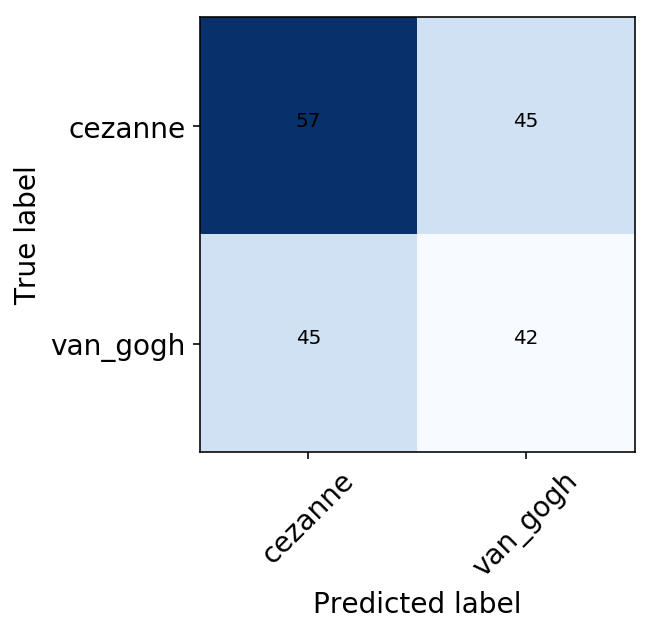

In [57]:
classes = ['cezanne', 'van_gogh']
conf_matrix_plot(predictions_df.actual_label, predictions_df.predicted_label, classes)

In [ ]:
# model.predict_classes(X_n_test_balanced)

In [59]:
print(classification_report(predictions_df['actual_label'], predictions_df['predicted_label']))

             precision    recall  f1-score   support

          0       0.56      0.56      0.56       102
          1       0.48      0.48      0.48        87

avg / total       0.52      0.52      0.52       189



In [60]:
import seaborn as sns

In [61]:
def roc(actual, preds):
    sns.set_style("dark")

    fpr_, tpr_, _ = roc_curve(actual, preds)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(actual)) + 0.5

    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=2,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=2, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('False positive rate', fontsize=14)
    axr.set_ylabel('True positive rate', fontsize=14)
    axr.set_title('Cezanne vs. van Gogh ROC curve\n', fontsize=16)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

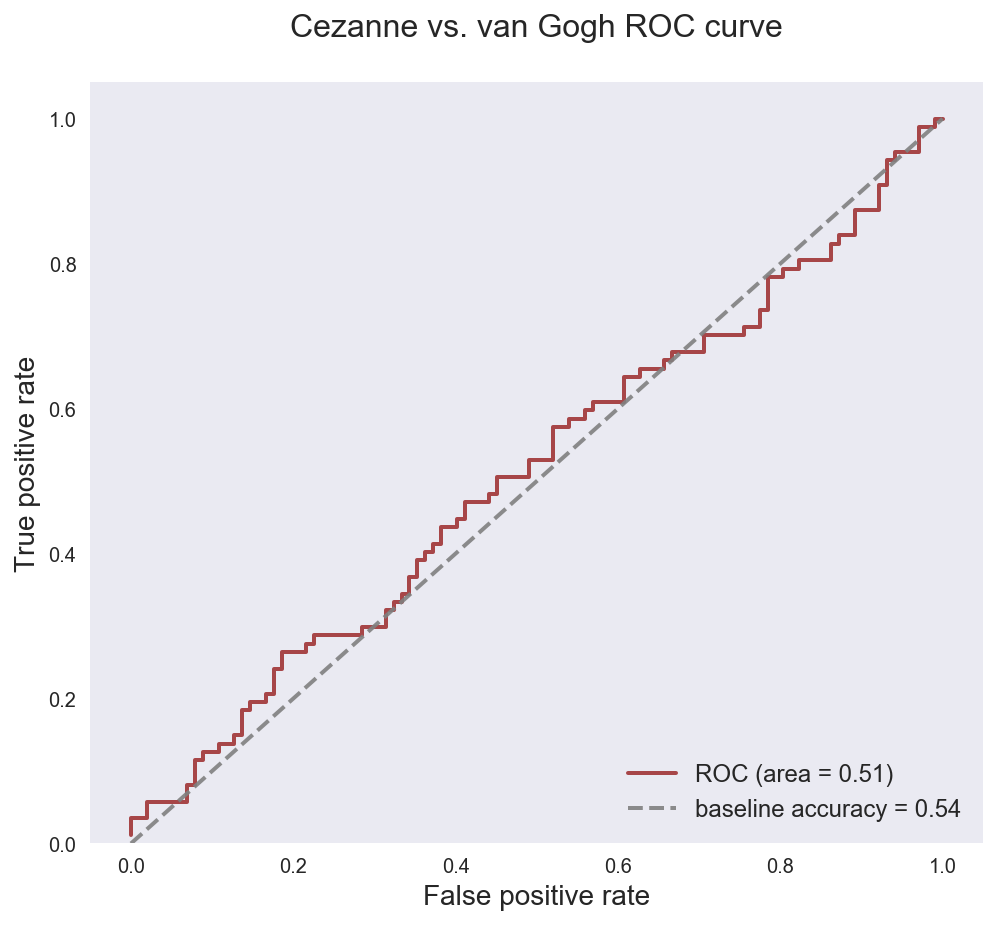

In [62]:
roc(predictions_df['actual_label'], predictions_df['predicted_probability'])

### Error Analysis
To better understand feature learning.

In [63]:
predictions_df.head()

,filepath,predicted_label,predicted_probability,actual_label
0,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.325690,1
1,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.029600,1
2,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.018283,1
3,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.063863,1
4,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.071713,1


In [64]:
predictions_df['predicted_artist'] = predictions_df.predicted_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')
predictions_df['true_artist'] = predictions_df.actual_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')
predictions_df.head()

,filepath,predicted_label,predicted_probability,actual_label,predicted_artist,true_artist
0,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.325690,1,Vincent van Gogh,Paul Cezanne
1,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.029600,1,Vincent van Gogh,Paul Cezanne
2,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.018283,1,Vincent van Gogh,Paul Cezanne
3,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.063863,1,Vincent van Gogh,Paul Cezanne
4,../painting_data/kaggle_paint_numbers/datagen_...,0.0,0.071713,1,Vincent van Gogh,Paul Cezanne


In [65]:
correct_mask = predictions_df.predicted_label == predictions_df.actual_label
correct = predictions_df[correct_mask]
top_correct = correct.sort_values(['predicted_probability'], ascending=False)[:5]
top_correct_idx = top_correct.index.values
top_correct_idx_list = top_correct_idx.tolist()

In [66]:
incorrect_mask = predictions_df.predicted_label != predictions_df.actual_label
incorrect = predictions_df[incorrect_mask]
top_incorrect = incorrect.sort_values(['predicted_probability'], ascending=False)[:5]
top_incorrect_idx = top_incorrect.index.values
top_incorrect_idx_list = top_incorrect_idx.tolist()

In [67]:
uncertain_mask = (predictions_df.predicted_probability.between(0.4, 0.6)) & (predictions_df.predicted_label != predictions_df.actual_label)
most_uncertain = predictions_df[uncertain_mask]
top_most_uncertain = most_uncertain.sort_values(['predicted_probability'], ascending=False)[:5]
top_most_uncertain_idx = top_most_uncertain.index.values
top_most_uncertain_idx_list = top_most_uncertain_idx.tolist()

In [68]:
def create_subset(artist, name):
    mask = train_paintings[artist] == name
    return train_paintings[mask].reset_index(drop=True)    

def create_array(subset):
    files = subset.new_filename
    return np.array([img_to_array(load_img('../painting_data/kaggle_paint_numbers/resized_72_test/' + fname)) for fname in files])

def display_from_array(series, array):
    for title, x in zip(series, array):
        img = array_to_img(x, data_format="channels_last")
        display(img)
        print(title)

In [69]:
X_test = create_array(cezanne_vangogh_test)

In [70]:
X_test.shape

(189, 72, 72, 3)

In [71]:
predictions_df['filepath'][0]

'../painting_data/kaggle_paint_numbers/datagen_modeling/validation/cezanne/103113.jpg'

In [72]:
predictions_df['predicted_artist']

0      Vincent van Gogh
1      Vincent van Gogh
2      Vincent van Gogh
3      Vincent van Gogh
4      Vincent van Gogh
5      Vincent van Gogh
6      Vincent van Gogh
7          Paul Cezanne
8      Vincent van Gogh
9      Vincent van Gogh
10     Vincent van Gogh
11     Vincent van Gogh
12     Vincent van Gogh
13     Vincent van Gogh
14         Paul Cezanne
15     Vincent van Gogh
16     Vincent van Gogh
17     Vincent van Gogh
18     Vincent van Gogh
19     Vincent van Gogh
20     Vincent van Gogh
21     Vincent van Gogh
22         Paul Cezanne
23     Vincent van Gogh
24     Vincent van Gogh
25         Paul Cezanne
26     Vincent van Gogh
27     Vincent van Gogh
28         Paul Cezanne
29     Vincent van Gogh
             ...       
159    Vincent van Gogh
160    Vincent van Gogh
161    Vincent van Gogh
162    Vincent van Gogh
163    Vincent van Gogh
164    Vincent van Gogh
165    Vincent van Gogh
166    Vincent van Gogh
167    Vincent van Gogh
168    Vincent van Gogh
169    Vincent v

In [73]:
def error_analysis(confidence):
    for i in confidence:
        x = X_test[i]
        x_reshape = x.reshape([72, 72, 3])
        x_display = array_to_img(x_reshape, data_format="channels_last")
        display(x_display)
        print("Prediction: {0} (probability: {1:.2f})\nTrue Label: {2}".format(predictions_df['predicted_artist'][i], 
                                                                               predictions_df['predicted_probability'][i], predictions_df['true_artist'][i]))
        print('------------------------------------------------')

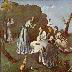

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


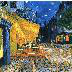

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


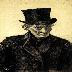

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


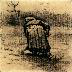

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


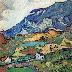

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


In [74]:
error_analysis(top_correct_idx_list)

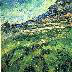

Prediction: Paul Cezanne (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


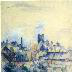

Prediction: Paul Cezanne (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


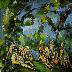

Prediction: Paul Cezanne (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


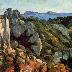

Prediction: Paul Cezanne (probability: 0.99)
True Label: Vincent van Gogh
------------------------------------------------


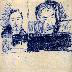

Prediction: Paul Cezanne (probability: 0.99)
True Label: Vincent van Gogh
------------------------------------------------


In [75]:
error_analysis(top_incorrect_idx_list)

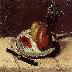

Prediction: Paul Cezanne (probability: 0.56)
True Label: Vincent van Gogh
------------------------------------------------


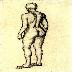

Prediction: Paul Cezanne (probability: 0.55)
True Label: Vincent van Gogh
------------------------------------------------


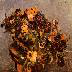

Prediction: Paul Cezanne (probability: 0.53)
True Label: Vincent van Gogh
------------------------------------------------


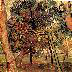

Prediction: Vincent van Gogh (probability: 0.49)
True Label: Paul Cezanne
------------------------------------------------


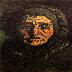

Prediction: Vincent van Gogh (probability: 0.49)
True Label: Paul Cezanne
------------------------------------------------


In [76]:
error_analysis(top_most_uncertain_idx_list)

# LIVE DEMO

### Canonical but "fake" van Gogh

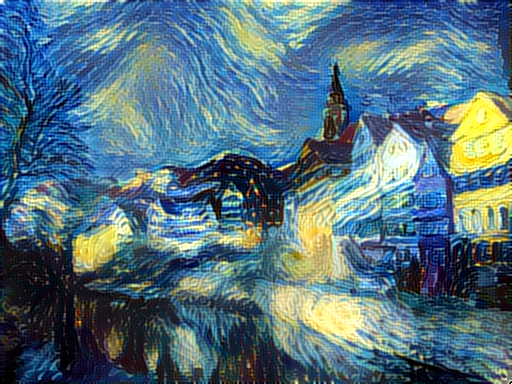

In [80]:
vangogh_style_path = '../painting_data/kaggle_paint_numbers/demo/vangogh.png'
vangogh_style_img = load_img(vangogh_style_path)
display(vangogh_style_img)

In [81]:
vangogh_style_img = vangogh_style_img.resize((72,72))
vangogh_style_img = img_to_array(vangogh_style_img)*(1./255.)
vangogh_style_img = vangogh_style_img.reshape((1,) + vangogh_style_img.shape)

In [83]:
final_model.predict_classes(vangogh_style_img)

1/1 [==============================] - 0s


array([[1]], dtype=int32)

In [84]:
final_model.predict_proba(vangogh_style_img)

1/1 [==============================] - 0s


array([[ 0.53943336]], dtype=float32)

### Canonical but "fake" Cezanne

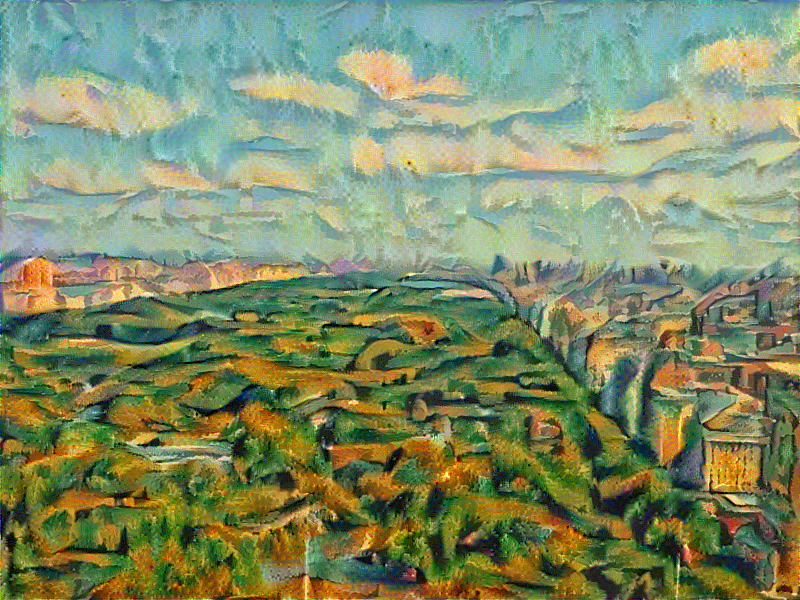

In [85]:
cezanne_style_path = '../painting_data/kaggle_paint_numbers/demo/cezanne.png'
cezanne_style_img = load_img(cezanne_style_path)
display(cezanne_style_img)

In [86]:
cezanne_style_img = cezanne_style_img.resize((72,72))
cezanne_style_img = img_to_array(cezanne_style_img)*(1./255.)
cezanne_style_img = cezanne_style_img.reshape((1,) + cezanne_style_img.shape)

In [87]:
final_model.predict_classes(cezanne_style_img)

1/1 [==============================] - 0s


array([[0]], dtype=int32)

In [88]:
final_model.predict_proba(cezanne_style_img)

1/1 [==============================] - 0s


array([[ 0.16884562]], dtype=float32)